# Import Librari & Data

In [55]:
import pyodbc
import sqlite3
import numpy as np 
import pandas as pd 
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules 

In [56]:
def ssms_to_sqlite():
    DB = {'servername': r'.',
        'database': 'johari'}

    ssms_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                        ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

    # Read data from the required tables
    product = pd.read_sql("SELECT * FROM rPRODUCT", ssms_conn)
    orders = pd.read_sql("SELECT * FROM ORDERS", ssms_conn)

    # Connect to SQLite database
    sqlite_conn = sqlite3.connect('../data/johari.db')

    # Write data to SQLite database
    product.to_sql('Table1', con=sqlite_conn, if_exists='replace', index=False)
    orders.to_sql('Table2', con=sqlite_conn, if_exists='replace', index=False)

    # Merge the two tables
    merged_table = pd.merge(orders, product, left_on='ORDER_PRODUCT_id', right_on='product_product_id')

    # Write the merged table to SQLite database
    merged_table.to_sql('OrderedProducts', con=sqlite_conn, if_exists='replace', index=False)

#ssms_to_sqlite()

go_sales_conn = sqlite3.connect('../data/go_sales.sqlite')
product = pd.read_sql_query('SELECT * FROM product', go_sales_conn)
order_details = pd.read_sql_query('SELECT * FROM order_details', go_sales_conn)

df = pd.merge(order_details, product, on='PRODUCT_NUMBER')
df.head()

,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,TRIAL879,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,TRIAL888
0,100000,8462,96,16,16.1,22.54,22.54,T,15-2-2011,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,T
1,100001,9111,96,20,16.1,22.54,22.54,T,15-2-2011,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,T
2,100002,8451,96,24,16.1,22.54,22.54,T,15-2-2011,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,T
3,100003,8453,96,18,16.1,22.54,22.54,T,15-2-2011,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,T
4,100004,8439,96,20,16.1,22.54,22.54,T,15-2-2011,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,T


# Clean Data

In [57]:
#Filter the columns that are required for the analysis

# Remove duplicates
df['PRODUCT_NAME'] = df['PRODUCT_NAME'].str.strip()
df.dropna(axis=0, subset=['ORDER_NUMBER'], inplace=True)

# Remove any rows where 'ORDER_quantity' is less than or equal to 0
df = df[df['QUANTITY'] > 0]

# Remove any rows where 'product_name' is empty or null
df = df[df['PRODUCT_NAME'].notna() & (df['PRODUCT_NAME'] != '')]

# Reset the index
df = df.reset_index(drop=True)

# Print the cleaned DataFrame
print(df.head())

  ORDER_DETAIL_CODE ORDER_NUMBER PRODUCT_NUMBER  QUANTITY UNIT_COST  \
0            100000         8462             96        16      16.1   
1            100001         9111             96        20      16.1   
2            100002         8451             96        24      16.1   
3            100003         8453             96        18      16.1   
4            100004         8439             96        20      16.1   

  UNIT_PRICE UNIT_SALE_PRICE TRIAL879 INTRODUCTION_DATE PRODUCT_TYPE_CODE  \
0      22.54           22.54        T         15-2-2011                17   
1      22.54           22.54        T         15-2-2011                17   
2      22.54           22.54        T         15-2-2011                17   
3      22.54           22.54        T         15-2-2011                17   
4      22.54           22.54        T         15-2-2011                17   

  PRODUCTION_COST MARGIN   PRODUCT_IMAGE LANGUAGE        PRODUCT_NAME  \
0           16.43    .28  P96OP4FA17.

# Build Model

In [58]:
basket = (df.groupby(['ORDER_NUMBER', 'PRODUCT_NAME'])['QUANTITY']
            .sum().unstack().reset_index().fillna(0)
            .set_index('ORDER_NUMBER'))

basket.head()

PRODUCT_NAME,Aloe Relief,Bear Edge,Bear Survival Edge,Blue Steel Max Putter,Blue Steel Putter,BugShield Extreme,BugShield Lotion,BugShield Lotion Lite,BugShield Natural,BugShield Spray,...,TrailChef Canteen,TrailChef Cook Set,TrailChef Cup,TrailChef Deluxe Cook Set,TrailChef Double Flame,TrailChef Kettle,TrailChef Kitchen Kit,TrailChef Single Flame,TrailChef Utensils,TrailChef Water Bag
ORDER_NUMBER,,,,,,,,,,,,,,,,,,,,,
1153,0.0,0.0,0.0,0.0,0.0,474.0,0.0,0.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0
1155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1156,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0
1157,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0


# One-Hot Encoding

In [59]:
# Define the hot encoding function
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

# Apply the hot encoding function to the basket_sets dataframe
basket_spooky = basket.applymap(hot_encode)
basket = basket_spooky

# Print the hot encoded data
basket.head()

C:\Users\noah\AppData\Local\Temp\ipykernel_9308\4065522448.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_spooky = basket.applymap(hot_encode)


PRODUCT_NAME,Aloe Relief,Bear Edge,Bear Survival Edge,Blue Steel Max Putter,Blue Steel Putter,BugShield Extreme,BugShield Lotion,BugShield Lotion Lite,BugShield Natural,BugShield Spray,...,TrailChef Canteen,TrailChef Cook Set,TrailChef Cup,TrailChef Deluxe Cook Set,TrailChef Double Flame,TrailChef Kettle,TrailChef Kitchen Kit,TrailChef Single Flame,TrailChef Utensils,TrailChef Water Bag
ORDER_NUMBER,,,,,,,,,,,,,,,,,,,,,
1153,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1155,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1156,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1157,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Model Bouwen

In [60]:
# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
frequent_itemsets.head()

c:\Users\noah\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.057463,(Aloe Relief)
1,0.082649,(Bear Edge)
2,0.073507,(Bear Survival Edge)
3,0.066791,(Blue Steel Max Putter)
4,0.072761,(Blue Steel Putter)


# Spooky RULES

In [61]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Blue Steel Max Putter),(Blue Steel Putter),0.066791,0.072761,0.020149,0.301676,4.146111,0.015289,1.327806,0.813119
1,(Blue Steel Putter),(Blue Steel Max Putter),0.072761,0.066791,0.020149,0.276923,4.146111,0.015289,1.290608,0.818355
2,(Blue Steel Max Putter),(Hailstorm Titanium Irons),0.066791,0.077985,0.025746,0.385475,4.942931,0.020538,1.500370,0.854783
3,(Hailstorm Titanium Irons),(Blue Steel Max Putter),0.077985,0.066791,0.025746,0.330144,4.942931,0.020538,1.393148,0.865160
4,(Hailstorm Titanium Woods Set),(Blue Steel Max Putter),0.062873,0.066791,0.022015,0.350148,5.242445,0.017816,1.436034,0.863543


# Visual Display

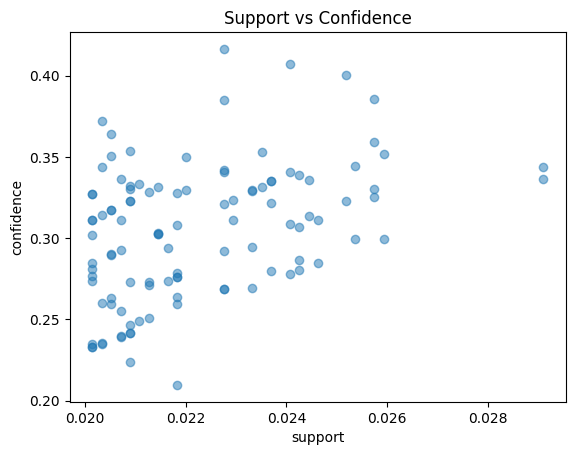

In [62]:
import matplotlib.pyplot as plt

plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

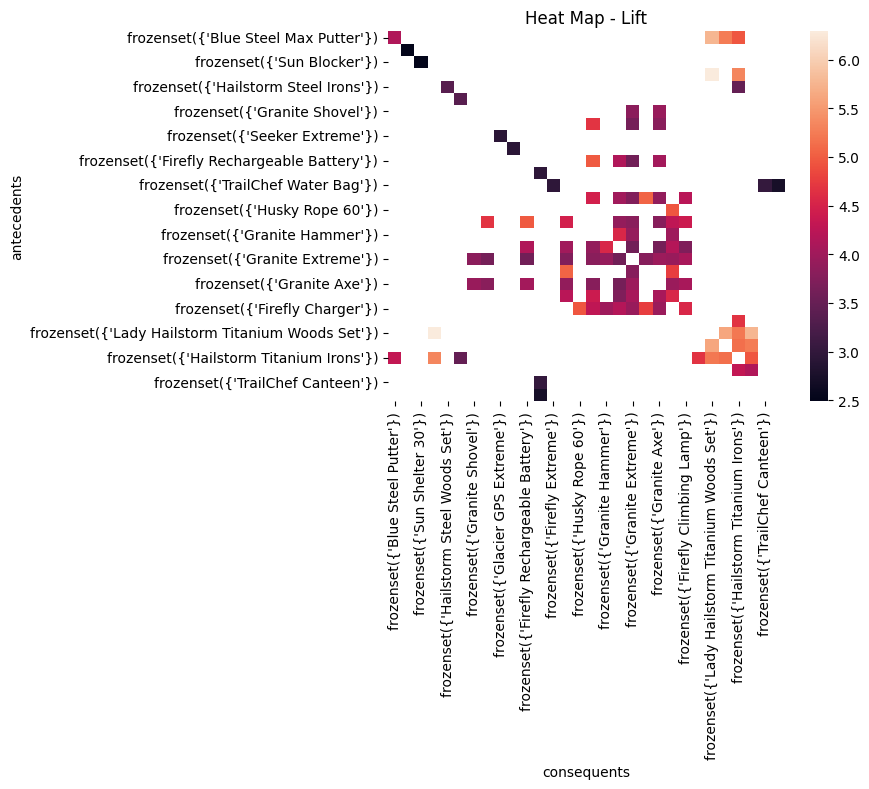

In [63]:
import seaborn as sns

pivot = rules.pivot(index='antecedents', columns='consequents', values='lift')
sns.heatmap(pivot)
plt.title('Heat Map - Lift')
plt.show()